# APPM 5720 Biweekly Report
### *Alexey Yermakov*
### *September 29, 2022*

# Summary
There were three primary focii of this report:  
1: Demonstrating overfitting   
2: Data Augmentation  
3: Transfer Learning  

# Main Content

## 1: Overfitting

In this section, we will observe how regularization plays a role in to prevent overfitting to data. In particular, we'll be fitting to a second order polynomial with some noise. We'll first do this without regularization, and then with regularization. I use low order polynomials and small training data sizes here for the sake of speeding up computation times, but the general ideas can be extended to higher order polynomials and other datsets.

In [1]:
# Self-explanatory imports
import keras.applications 
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os

# Allows the plots to appear in a notebook
%matplotlib inline

# Limits GPU usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024*5)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-xlppoorq because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


1 Physical GPUs, 1 Logical GPUs


Let's define the polynomial we'll be working with.
<div>
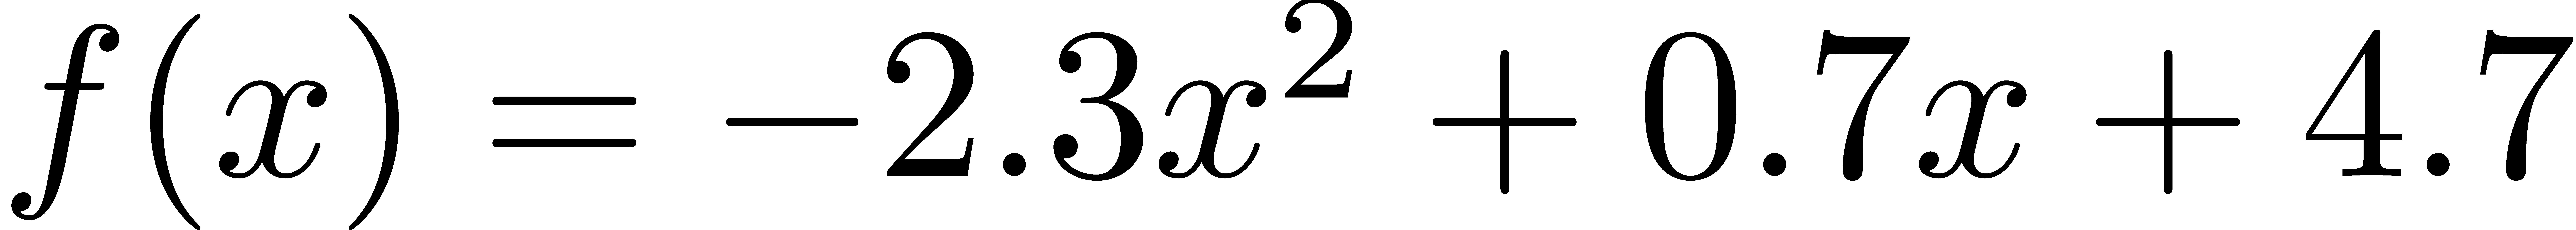
</div>

In [2]:
f = lambda x: - 2.3*x**2 + 0.7*x + 4.7

Now, lets get some testing data. This testing data will be spread uniformly over the interval [-1.5,2.5] with noise which is normally distributed.

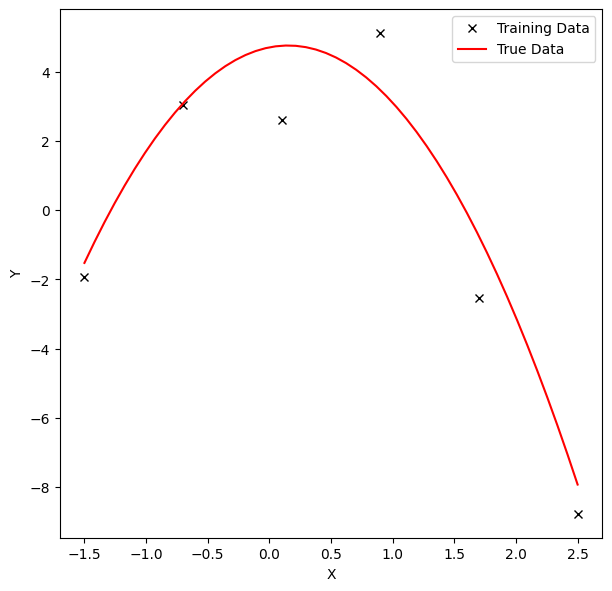

In [3]:
# Define our domain
min_x = -1.5
max_x = 2.5
x_num = 6

# Constant seed
np.random.seed(2) # 1 is good, 

# Noise amount
stdev = 1

# Create our training points
x_t = np.linspace(min_x,max_x, x_num)
y_t = f(x_t) + np.random.normal(0,stdev,x_num)

# Create our true points, helps with graphing
x = np.linspace(min_x,max_x,num=50)
y = f(x)

# Plot our data
fig, ax = plt.subplots(1,1,figsize=(7,7), dpi=100, facecolor='white')

#ax.set_facecolor('white')
ax.plot(x_t, y_t, linestyle='none', marker='x', color='black', label="Training Data")
ax.plot(x, y, color='red', label="True Data")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()

In my previous report I was able to fit a model to a polynomial, so I'll be re-using that code here.

poly_str is [x**1,x**2]


Text(0.5, 1.0, 'Keras training progress')

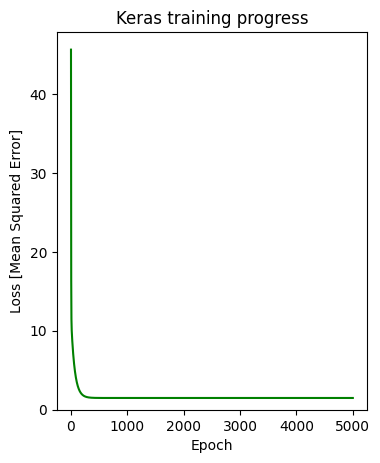

In [4]:
# Helper function for defining different types of models
def train_model(power, weight_reg, bias_reg, epochs, SGD_rate):
    # power: Define the order of the polynomial we're fitting
    # weight_reg: lambda for weight regularization
    # bias_reg: lambda for bias regularization
    # epochs: epochs to run
    # SGD_rate: learning rate for SGD

    # Create input data
    X_t = np.asarray([x_t ** i for i in range(1,power+1)]).transpose()

    # Create a list defining our polynomial without coefficients
    # Something like: "[x**1, ..., x**power]", note the constant term is accounted for in the bias
    # I couldn't think of a better way of doing this...
    poly_str = "["
    for i in range(1,power+1):
        poly_str += f"x**{i},"
    poly_str = poly_str[:-1] + "]"

    print("poly_str is",poly_str)

    # Create a keras model
    model = tf.keras.Sequential([
    #tf.keras.Input(shape=(power,)),
    #tf.keras.layers.Lambda(lambda x: tf.stack(eval(poly_str), axis=1)),
    tf.keras.layers.Dense(1, kernel_initializer=tf.random.normal,\
                         bias_regularizer=tf.keras.regularizers.L2(bias_reg),\
                         kernel_regularizer=tf.keras.regularizers.L2(weight_reg))])

    # Set the loss function and optimizer
    model.compile(
        loss=tf.keras.losses.MSE, # Use least squares
        optimizer=tf.keras.optimizers.SGD(learning_rate=SGD_rate))

    # Run the actual optimization
    history = model.fit(X_t, y_t,
                        epochs=epochs,
                        verbose=0)

    running_loss = np.asarray(history.history['loss'])
    
    return model, running_loss

# Train our model, 2nd power, no regularization, 5000 epochs, SGD learning rate of 0.01
model_1, running_loss_1 = train_model(2, 0, 0, 5000, 0.01)
    
# Plot our training progress
plt.figure(figsize=(4,5),dpi=100, facecolor='white')
plt.plot(running_loss_1, color='green')
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss [Mean Squared Error]')
plt.title('Keras training progress')

In [5]:
weights = model_1.weights
print()
print("x^2 coeff should be -2.3, is", weights[0][1][0].numpy())
print("x   coeff should be 0.7,  is", weights[0][0][0].numpy())
print("bias      should be 4.7,  is", weights[1][0].numpy())


x^2 coeff should be -2.3, is -2.3686042
x   coeff should be 0.7,  is 0.6414642
bias      should be 4.7,  is 4.27378


Great! So in the above, we fit a model to a 2-nd degree polynomial, so we'd expect our model to fit to the true model pretty well, despite some noise. Note that I ran into a problem originally where my loss function kept growing until it hit `nan`, this was resolved by lowering the learning rate of SGD until I no longer got `nan`. For higher order polynomials I had to further reduce the SGD learning rate, and in turn increase the number of epochs.

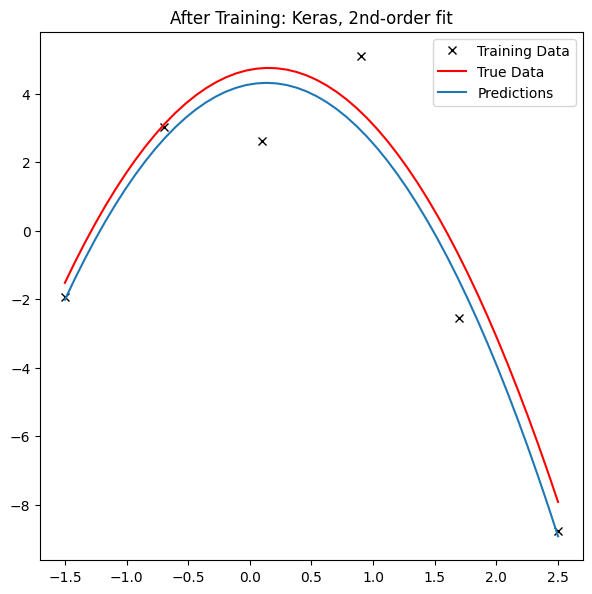

In [6]:
# Helper function for plotting our true and modeled functions
def plot_poly(f, model, power, title):
    # Plot our data
    fig, ax = plt.subplots(1,1,figsize=(7,7), dpi=100, facecolor='white')
    
    ax.plot(x_t, y_t, linestyle='none', marker='x', color='black', label="Training Data")
    
    ax.plot(x, y, color='red', label="True Data")
    
    X = np.asarray([x ** i for i in range(1,power+1)]).transpose()
    plt.plot(x, model(X).numpy().flatten(), label='Predictions')
    
    plt.title(title)
    plt.legend()
    
plot_poly(f, model_1, 2, "After Training: Keras, 2nd-order fit")

Now let's fit to a higher degree polynomial (5th degree in this case)!

poly_str is [x**1,x**2,x**3,x**4,x**5]


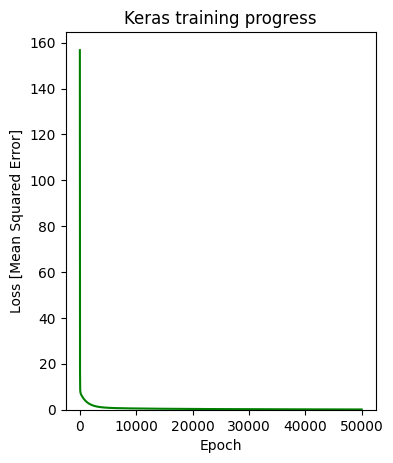

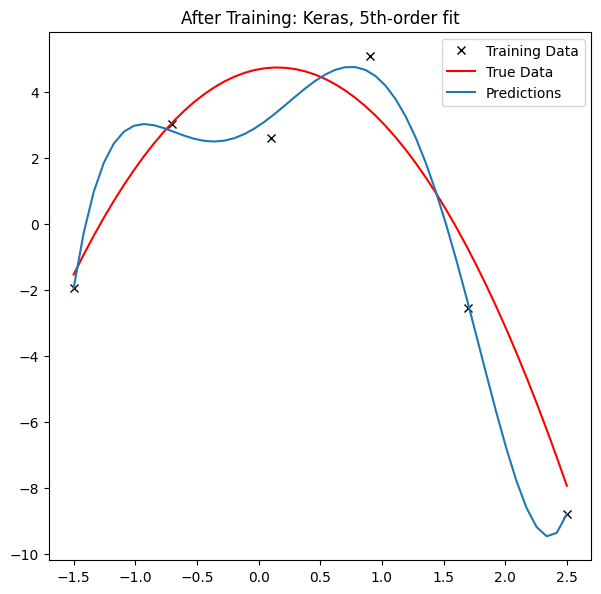

In [7]:
# Train our model, 5th power, no regularization, 50000 epochs, SGD learning rate of 0.0005
model_2, running_loss_2 = train_model(5, 0, 0, 50000, 0.0005)

# Plot our training progress
plt.figure(figsize=(4,5),dpi=100, facecolor='white')
plt.plot(running_loss_2, color='green')
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss [Mean Squared Error]')
plt.title('Keras training progress');

plot_poly(f, model_2, 5, "After Training: Keras, 5th-order fit")

In [8]:
weights = model_2.weights
print()
print("x^5 coeff should be 0,    is", weights[0][4][0].numpy())
print("x^4 coeff should be 0,    is", weights[0][3][0].numpy())
print("x^3 coeff should be 0,    is", weights[0][2][0].numpy())
print("x^2 coeff should be 0.7,  is", weights[0][1][0].numpy())
print("x   coeff should be -2.3, is", weights[0][0][0].numpy())
print("bias      should be 4.7,  is", weights[1][0].numpy())


x^5 coeff should be 0,    is 0.8385809
x^4 coeff should be 0,    is -1.9025598
x^3 coeff should be 0,    is -2.6684306
x^2 coeff should be 0.7,  is 2.5803134
x   coeff should be -2.3, is 2.4905841
bias      should be 4.7,  is 2.983424


From the above we can see that our higher degree polynomial fit the training data much better! This, however, does not mean we fit to the true data better. In the below graph we can see that for x just outside the domain of our polynomial, our 5th order model diverges exponentially quickly compared to the 2nd order model. In fact, I chose an odd-order for the higher order model specifically to show this behavior. This is why it's so important to choose the right model for our task, since we can have some strange behavior outside of our training data, including but not limited to overfitting.

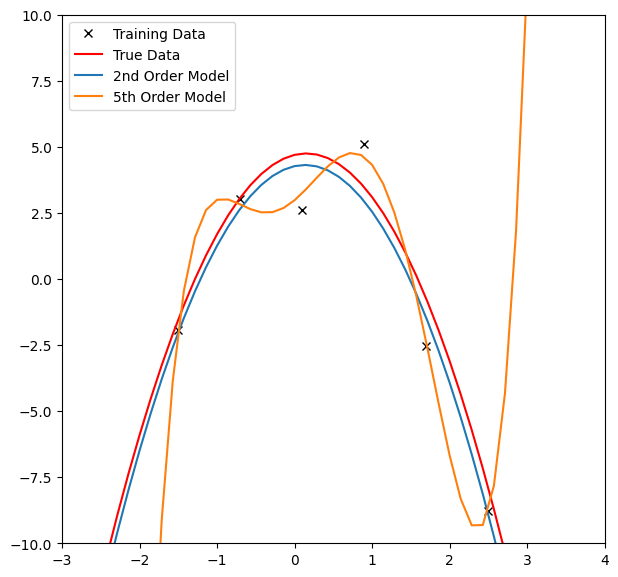

In [9]:
# Plot our data
x_larger = np.linspace(-3,4,num=50)
y_larger = f(x_larger)

fig, ax = plt.subplots(1,1,figsize=(7,7), dpi=100, facecolor='white')
    
ax.plot(x_t, y_t, linestyle='none', marker='x', color='black', label="Training Data")
    
ax.plot(x_larger, y_larger, color='red', label="True Data")
    
X = np.asarray([x_larger ** i for i in range(1,2+1)]).transpose()
plt.plot(x_larger, model_1(X).numpy().flatten(), label='2nd Order Model')

X = np.asarray([x_larger ** i for i in range(1,5+1)]).transpose()
plt.plot(x_larger, model_2(X).numpy().flatten(), label='5th Order Model')

plt.ylim(-10,10)
plt.xlim(-3,4)
    
plt.legend()

Lets add some regularization and see what happens. In this case, I add ridge regression on the weights and biases of the single dense layer of my model.

poly_str is [x**1,x**2,x**3,x**4,x**5]


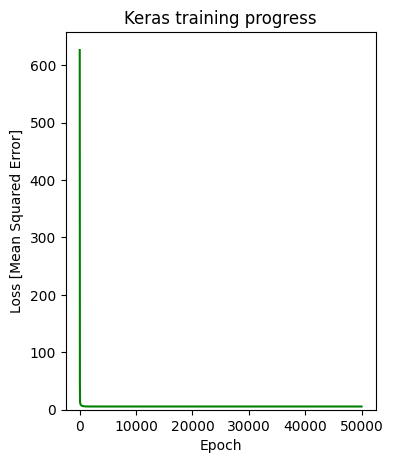

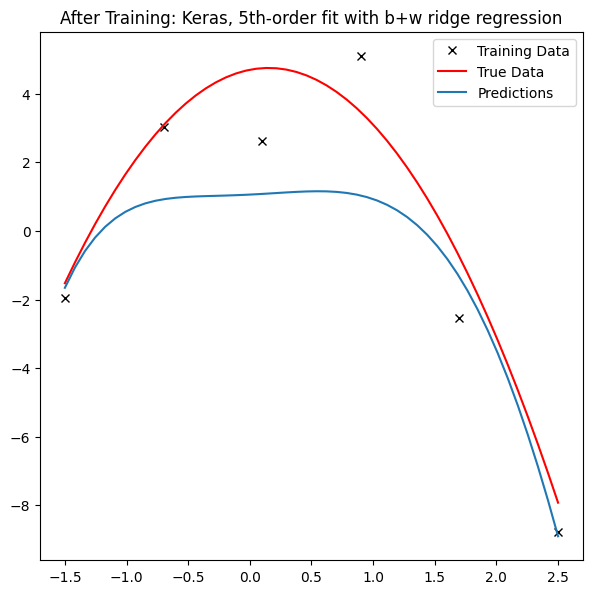

In [10]:
# Train our model, 5th power, lambda 1 regularization for weights and biases, 50000 epochs, 
#   SGD learning rate of 0.0005
model_3, running_loss_3 = train_model(5, 1, 1, 50000, 0.0005)

# Plot our training progress
plt.figure(figsize=(4,5),dpi=100, facecolor='white')
plt.plot(running_loss_3, color='green')
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss [Mean Squared Error]')
plt.title('Keras training progress');

plot_poly(f, model_3, 5, "After Training: Keras, 5th-order fit with b+w ridge regression")

What if we don't have bias regularization?

poly_str is [x**1,x**2,x**3,x**4,x**5]


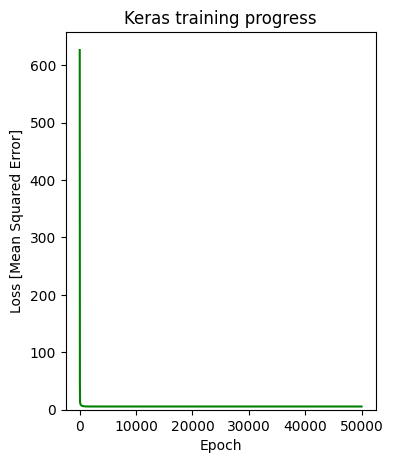

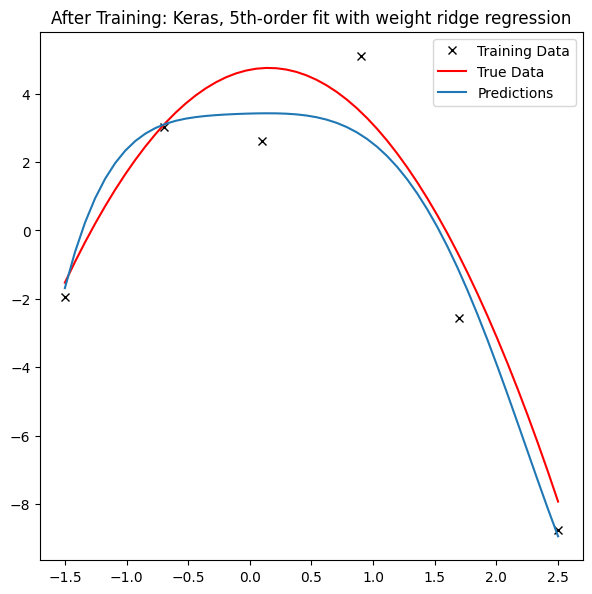

In [11]:
# Train our model, 5th power, lambda 1 regularization for weights, 50000 epochs, 
#   SGD learning rate of 0.0005
model_4, running_loss_4 = train_model(5, 1, 0, 50000, 0.0005)

# Plot our training progress
plt.figure(figsize=(4,5),dpi=100, facecolor='white')
plt.plot(running_loss_3, color='green')
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss [Mean Squared Error]')
plt.title('Keras training progress');

plot_poly(f, model_4, 5, "After Training: Keras, 5th-order fit with weight ridge regression")

So, observing the last two models, it's clear that regularization for the weights but not the biases is a better option for fitting a 5th order polynomial to a 2nd order polynomial. I'm sure in some cases bias regularization would be beneficial, but it is not in this case. The reason might be because of the model we're fitting to: we know that the bias term is a constant which is non-zero because of the function we're approximating to, and adding regularization will effectively lower our model relative to the y-axis, making our predictions worse. Let's plot these two regularized models on a single graph.

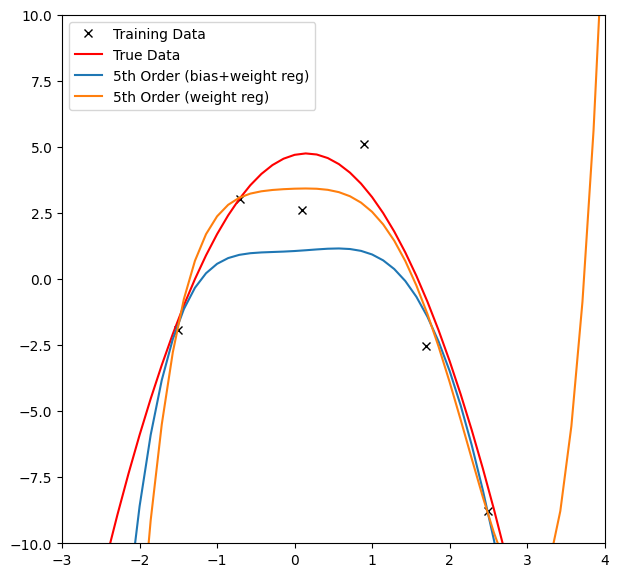

In [12]:
# Plot our data
x_larger = np.linspace(-3,4,num=50)
y_larger = f(x_larger)

fig, ax = plt.subplots(1,1,figsize=(7,7), dpi=100, facecolor='white')
    
ax.plot(x_t, y_t, linestyle='none', marker='x', color='black', label="Training Data")
    
ax.plot(x_larger, y_larger, color='red', label="True Data")

X = np.asarray([x_larger ** i for i in range(1,5+1)]).transpose()
plt.plot(x_larger, model_3(X).numpy().flatten(), label='5th Order (bias+weight reg)')

X = np.asarray([x_larger ** i for i in range(1,5+1)]).transpose()
plt.plot(x_larger, model_4(X).numpy().flatten(), label='5th Order (weight reg)')

plt.ylim(-10,10)
plt.xlim(-3,4)
    
plt.legend()

Once again, we see that regularization in the weights helped our 5th order model approximate our 2nd order model better (given the sparse amount of training data), and that bias regularization was harmful.

Thus, I have demonstrated the problems of overfitting and the bandaid of regularization. Regularization isn't perfect, as can be seen in this case, since theoretically we could have our 5th order model be exactly equal to our 2nd order model by having the 3rd through 5th order coefficients as 0. However, due to the sparse amount of data and the nature of the 5th order model, regularization is helpful when those higher order terms can't be assumed to be 0.

## 2: Data Augmentation

I want to use the following formula to augment images (the same formula was presented in [class, slide 7](https://raw.githubusercontent.com/maziarraissi/Applied-Deep-Learning/main/01%20-%20Computer%20Vision/01%20-%20Image%20Classification/01%20-%20Large%20Networks.pdf))

<img src="Images/PixelAugmentation.jpg" alt="Pixel Augmentation Formula" width="600"/>

The `I` vectors represent individual pixels at location `x`,`y`. The array `[p1,p2,p3]` represents the eigenvectors of our covariance matrix. The `alpha` values are from a gaussian distribution with mean `0` and standard deviation `0.1`. Finally, the `lambda`'s are the eigenvalues of our covariance matrix.  
The first block of code just has some imports of libraries I will be using and sets Tensorflow's expectation of how much memory it has available to it.

I first want to compute the covariance matrix of the input image. We know that based on [this page](https://en.wikipedia.org/wiki/Estimation_of_covariance_matrices) that the way we compute the sample covariance matrix is by interpreting each pixel of our image as an "observation" of a random vector. The below formula then shows us how to compute the covariance matrix.

<img src="./Images/Cov.jpg" alt="Covariance Formula" width="350"/>

So, we first need to convert our image from a tensor of size `WxHx3` to a tensor of size `(W*H)x3`, where we just put all of our pixels in a row. Below, I show a proof of concept for this manipulation by defining a 2x2 pixel image, where each pixel is a 3D vector.

Input tensor:
[[[54, 255, 80], [119, 51, 255]], [[230, 0, 153], [153, 51, 0]]]

Output tensor:
[[ 54 255  80]
 [119  51 255]
 [230   0 153]
 [153  51   0]]



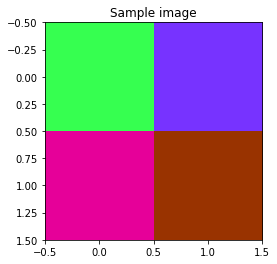

In [13]:
# Function to convert our image to a row of pixels
def img_to_row(img):
    arr = np.asarray(img)
    row = np.concatenate(arr, axis=0)
    return row

in_arr = [[[54,255,80],[119,51,255]],[[230,0,153],[153,51,0]]]
print("Input tensor:")
print(in_arr)
print()

out_arr = img_to_row(in_arr)
print("Output tensor:")
print(out_arr)

plt.imshow(in_arr)
plt.title("Sample image")
print()

We can now compute the covariance matrix of our input image. I'll be using a numpy function for this. We know that our output dimensions are 3x3 based on the above covariance formula, so we need to set the appropriate parameters in numpy's [covariance function](https://numpy.org/doc/stable/reference/generated/numpy.cov.html) so that the output is what we expected. In particular, we change the `rowvar` parameter.

In [14]:
print("Incorrect covariance:")
print(np.cov(out_arr, rowvar=True))
print()
print("Correct covariance:")
print(np.cov(out_arr, rowvar=False))

cov = np.cov(out_arr, rowvar=False)

Incorrect covariance:
[[ 11950.33333333  -7638.66666667 -12501.16666667  -2592.5       ]
 [ -7638.66666667  10789.33333333   6063.33333333  -4046.        ]
 [-12501.16666667   6063.33333333  13706.33333333   4573.        ]
 [ -2592.5         -4046.           4573.           6069.        ]]

Correct covariance:
[[ 5367.33333333 -7327.           674.33333333]
 [-7327.         12788.25       -3383.        ]
 [  674.33333333 -3383.         11766.        ]]


We can now compute the eigenvalues and eigenvectors of our covariance matrix.

In [15]:
# Get eigenvalues and eigenvectors
eig = np.linalg.eig(cov)

eig_val = eig[0]
eig_vec  = eig[1]

print("Eigenvalues:")
print(eig[0])
print()
print("Eigenvectors:")
print(eig[1])

Eigenvalues:
[  727.24750537 18796.66412844 10397.67169953]

Eigenvectors:
[[ 0.83452486  0.4504834  -0.317227  ]
 [ 0.53900375 -0.78684894  0.30057229]
 [ 0.11420691  0.42182159  0.89945724]]


While getting this pixel transformation to work for the entire image, I realized that I needed to convert my images from having integer pixels to floating point pixels, so I divided each scalar in the image by 255.

Original:
[[[ 54 255  80]
  [119  51 255]]

 [[230   0 153]
  [153  51   0]]]

Modified:
[[[0.21176471 1.         0.31372549]
  [0.46666667 0.2        1.        ]]

 [[0.90196078 0.         0.6       ]
  [0.6        0.2        0.        ]]]



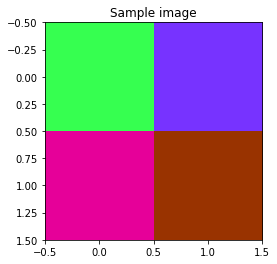

In [16]:
# Converts an image with pixel values containing integers in [0,255] to pixels containing floats in [0.0,1.0]
def to_float(input_img, prints = False):
    # Get dimensions of our input image
    shape = input_img.shape
    
    if prints:
        print("Converting image to float")
    
    total_pix = shape[0]*shape[1]*shape[2]
    
    # Generate output image
    output_img = np.zeros(shape)
    for x in range(shape[0]):
        for y in range(shape[1]):
            for z in range(shape[2]):
                if prints:
                    scale = (total_pix//200)
                    num = x*shape[1]*shape[2]+y*shape[2]+z
                    if scale != 0:
                        if num % scale == 0:
                            print(f"Augmented {num} of {total_pix} pixels [{num/total_pix*100:.1f} %]")
                output_img[x][y][z] = input_img[x][y][z]/255
                
    return output_img


in_arr = np.asarray([[[54,255,80],[119,51,255]],[[230,0,153],[153,51,0]]])
in_arr_f = to_float(in_arr)

print("Original:")
print(in_arr)
print()
print("Modified:")
print(in_arr_f)

plt.imshow(in_arr_f)
plt.title("Sample image")
print()

Lastly, let's test out the full transformation function on a sample 43x42 pixel image. I chose this small image because the processing time for larger images was large.

Input image:
[[[ 54 255  80]
  [119  51 255]]

 [[230   0 153]
  [153  51   0]]]

Input image scaled to [0.0,1.0]
[[[0.21176471 1.         0.31372549]
  [0.46666667 0.2        1.        ]]

 [[0.90196078 0.         0.6       ]
  [0.6        0.2        0.        ]]]

Computing Covariance
[[ 0.08254261 -0.11267974  0.01037037]
 [-0.11267974  0.19666667 -0.05202614]
 [ 0.01037037 -0.05202614  0.18094579]]

Computing eigenvectors and eigenvalues
Eigenvalues:
[0.01118412 0.28906827 0.15990268]
Eigenvectors:
[[ 0.83452486  0.4504834  -0.317227  ]
 [ 0.53900375 -0.78684894  0.30057229]
 [ 0.11420691  0.42182159  0.89945724]]

Augmenting Image

Output image:
[[[ 0.18317443  1.04027391  0.29534733]
  [ 0.43807639  0.24027391  0.98162184]]

 [[ 0.8733705   0.04027391  0.58162184]
  [ 0.57140972  0.24027391 -0.01837816]]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


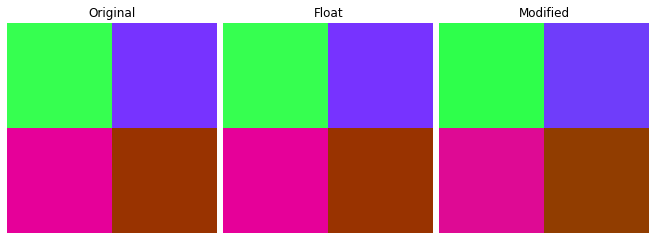

In [17]:
# Performs the augment operation pixel-by-pixel
def augment(input_img, alphas, prints=False):
    # Eigenvalues and eigenvectors of our covariance matrix
    if prints:
        print("Computing Covariance")
    
    cov = np.cov(img_to_row(input_img), rowvar=False)
                 
    if prints:
        print(cov)
        print()
        print("Computing eigenvectors and eigenvalues")
                
    eig = np.linalg.eig(cov)
    eig_val = eig[0]
    eig_vec  = eig[1]
    
    if prints:
        print("Eigenvalues:")
        print(eig_val)
        print("Eigenvectors:")
        print(eig_vec)
        print()

    # Get dimensions of our input image
    shape = input_img.shape
    
    # Keep track of status
    total_pix = shape[0]*shape[1]

    if prints:
        print("Augmenting Image")
        
    # Generate output image
    output_img = np.zeros(shape)
    for x in range(shape[0]):
        for y in range(shape[1]):
            if prints:
                scale = (total_pix//200)
                num = x*shape[1]+y
                if scale != 0:
                    if num % scale == 0:
                        print(f"Augmented {num} of {total_pix} pixels [{num/total_pix*100:.1f} %]")
            # mat3: This is the [a1 lambda1, a2 lambda2, a3, lambda3] vector
            mat_3 = np.vstack([alphas[i]*eig_val[i] for i in range(3)])
            # new_p: This is our new pixel, but we need to transpose it back to
            #        the same shape as our input image
            new_p = np.vstack(input_img[x][y])+np.matmul(np.transpose(eig_vec),mat_3)
            output_img[x][y] = np.hstack(new_p)
    
    return output_img


        
# Sample image
print("Input image:")
sample_img = np.asarray([[[54,255,80],[119,51,255]],[[230,0,153],[153,51,0]]])
print(sample_img)
print()

# Scale the sample image (this works better from trial and error)
print("Input image scaled to [0.0,1.0]")
sample_img_float = to_float(sample_img)
print(sample_img_float)
print()

# Generate our alphas (using constant alphas in this case)
# alphas = np.random.normal(0, 0.1, 3)
alphas = [0.0101462, -0.18204598, -0.01755552] # Pre-generated

# Augment our image
output_img = augment(sample_img_float, alphas, True)
print()
print("Output image:")
print(output_img)


#################################################
# Plot our original scaled, and augmented image #
#################################################

# Print first ncols*nrows images
ncols = 3
nrows = 1
fig1, f1_axes = plt.subplots(ncols=ncols, nrows=nrows, constrained_layout=True, figsize=(9,9))
num_images = ncols*nrows

# Make our grid and populate it with images
ax = f1_axes[0]
# Turn off axes and grid markers
ax.set_axis_off()
# Add the image
ax.imshow(sample_img)
# Ugly string manipulation to make the title's pretty:
ax.set_title("Original")

# Make our grid and populate it with images
ax = f1_axes[1]
# Turn off axes and grid markers
ax.set_axis_off()
# Add the image
ax.imshow(sample_img_float)
# Ugly string manipulation to make the title's pretty:
ax.set_title("Float")

# Make our grid and populate it with images
ax = f1_axes[2]
# Turn off axes and grid markers
ax.set_axis_off()
# Add the image
ax.imshow(output_img)
# Ugly string manipulation to make the title's pretty:
ax.set_title("Modified")
    
plt.show()

The good news is that everything ran just fine! The bad news is I can't tell there is any difference. Things are working fine, which I'll show in just a moment, but lets review some of the functions I used above.

There are some new numpy functions above that we haven't seen earlier. This is what they are and what they do:
  - [`np.vstack`](https://numpy.org/doc/stable/reference/generated/numpy.vstack.html): Convert a 1xD array to Dx1
  - [`np.hstack`](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html): Convert a Dx1 array to 1xD
  - [`np.zeros`](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html): Create a new tensor of size `shape` with every element being `0`
  - [`np.matlmul`](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html): Typical matrix multiplication
  - [`np.transpose`](https://numpy.org/doc/stable/reference/generated/numpy.transpose.html): Transposes the matrix, note that this doesn't work for 1D arrays for some reason and I had to use `vstack` and `hstack` instead
  - [`np.random.normal`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html): Samples from a random distribution with a specified mean and standard deviation

Below I show simple examples of these functions

In [18]:
# vstack example
t1 = np.asarray([1,2,3])
print("Before vstack")
print(t1)
print()
print("After vstack")
val = np.vstack(t1)
print(val)
print()

# transpose example
t2 = [[1,2,3],[4,5,6],[7,8,9]]
print("Before transpose")
print(t2)
print()
print("After transpose")
print(np.transpose(t2))
print()

# matrix multiplication example
print("Matrix multiplication of A*B:")
print("A:")
print(t2)
print()
print("B:")
print(val)
print()
print("A*B:")
val2 = np.matmul(t2,val)
print(val2)
print()

# hstack example
print("Before hstack")
print(val2)
print()
print("After hstack")
print(np.hstack(val2))
print()

# normal distribution example
print("3 Samples from a normal distribution:")
print(np.random.normal(0, 0.1, 3))
print()

# 2x2 zero matrix example
print("A 2x2 zero-d matrix:")
print(np.zeros((2,2)))


Before vstack
[1 2 3]

After vstack
[[1]
 [2]
 [3]]

Before transpose
[[1, 2, 3], [4, 5, 6], [7, 8, 9]]

After transpose
[[1 4 7]
 [2 5 8]
 [3 6 9]]

Matrix multiplication of A*B:
A:
[[1, 2, 3], [4, 5, 6], [7, 8, 9]]

B:
[[1]
 [2]
 [3]]

A*B:
[[14]
 [32]
 [50]]

Before hstack
[[14]
 [32]
 [50]]

After hstack
[14 32 50]

3 Samples from a normal distribution:
[ 0.05028814 -0.12452881 -0.10579522]

A 2x2 zero-d matrix:
[[0. 0.]
 [0. 0.]]


Now that we have a function for modifying any image, let's apply it to a real image! I used a 42x43 pixel image to speed up the processing time since my code is not optimized by any means. The titles of the images below are the alpha values used to augment the image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


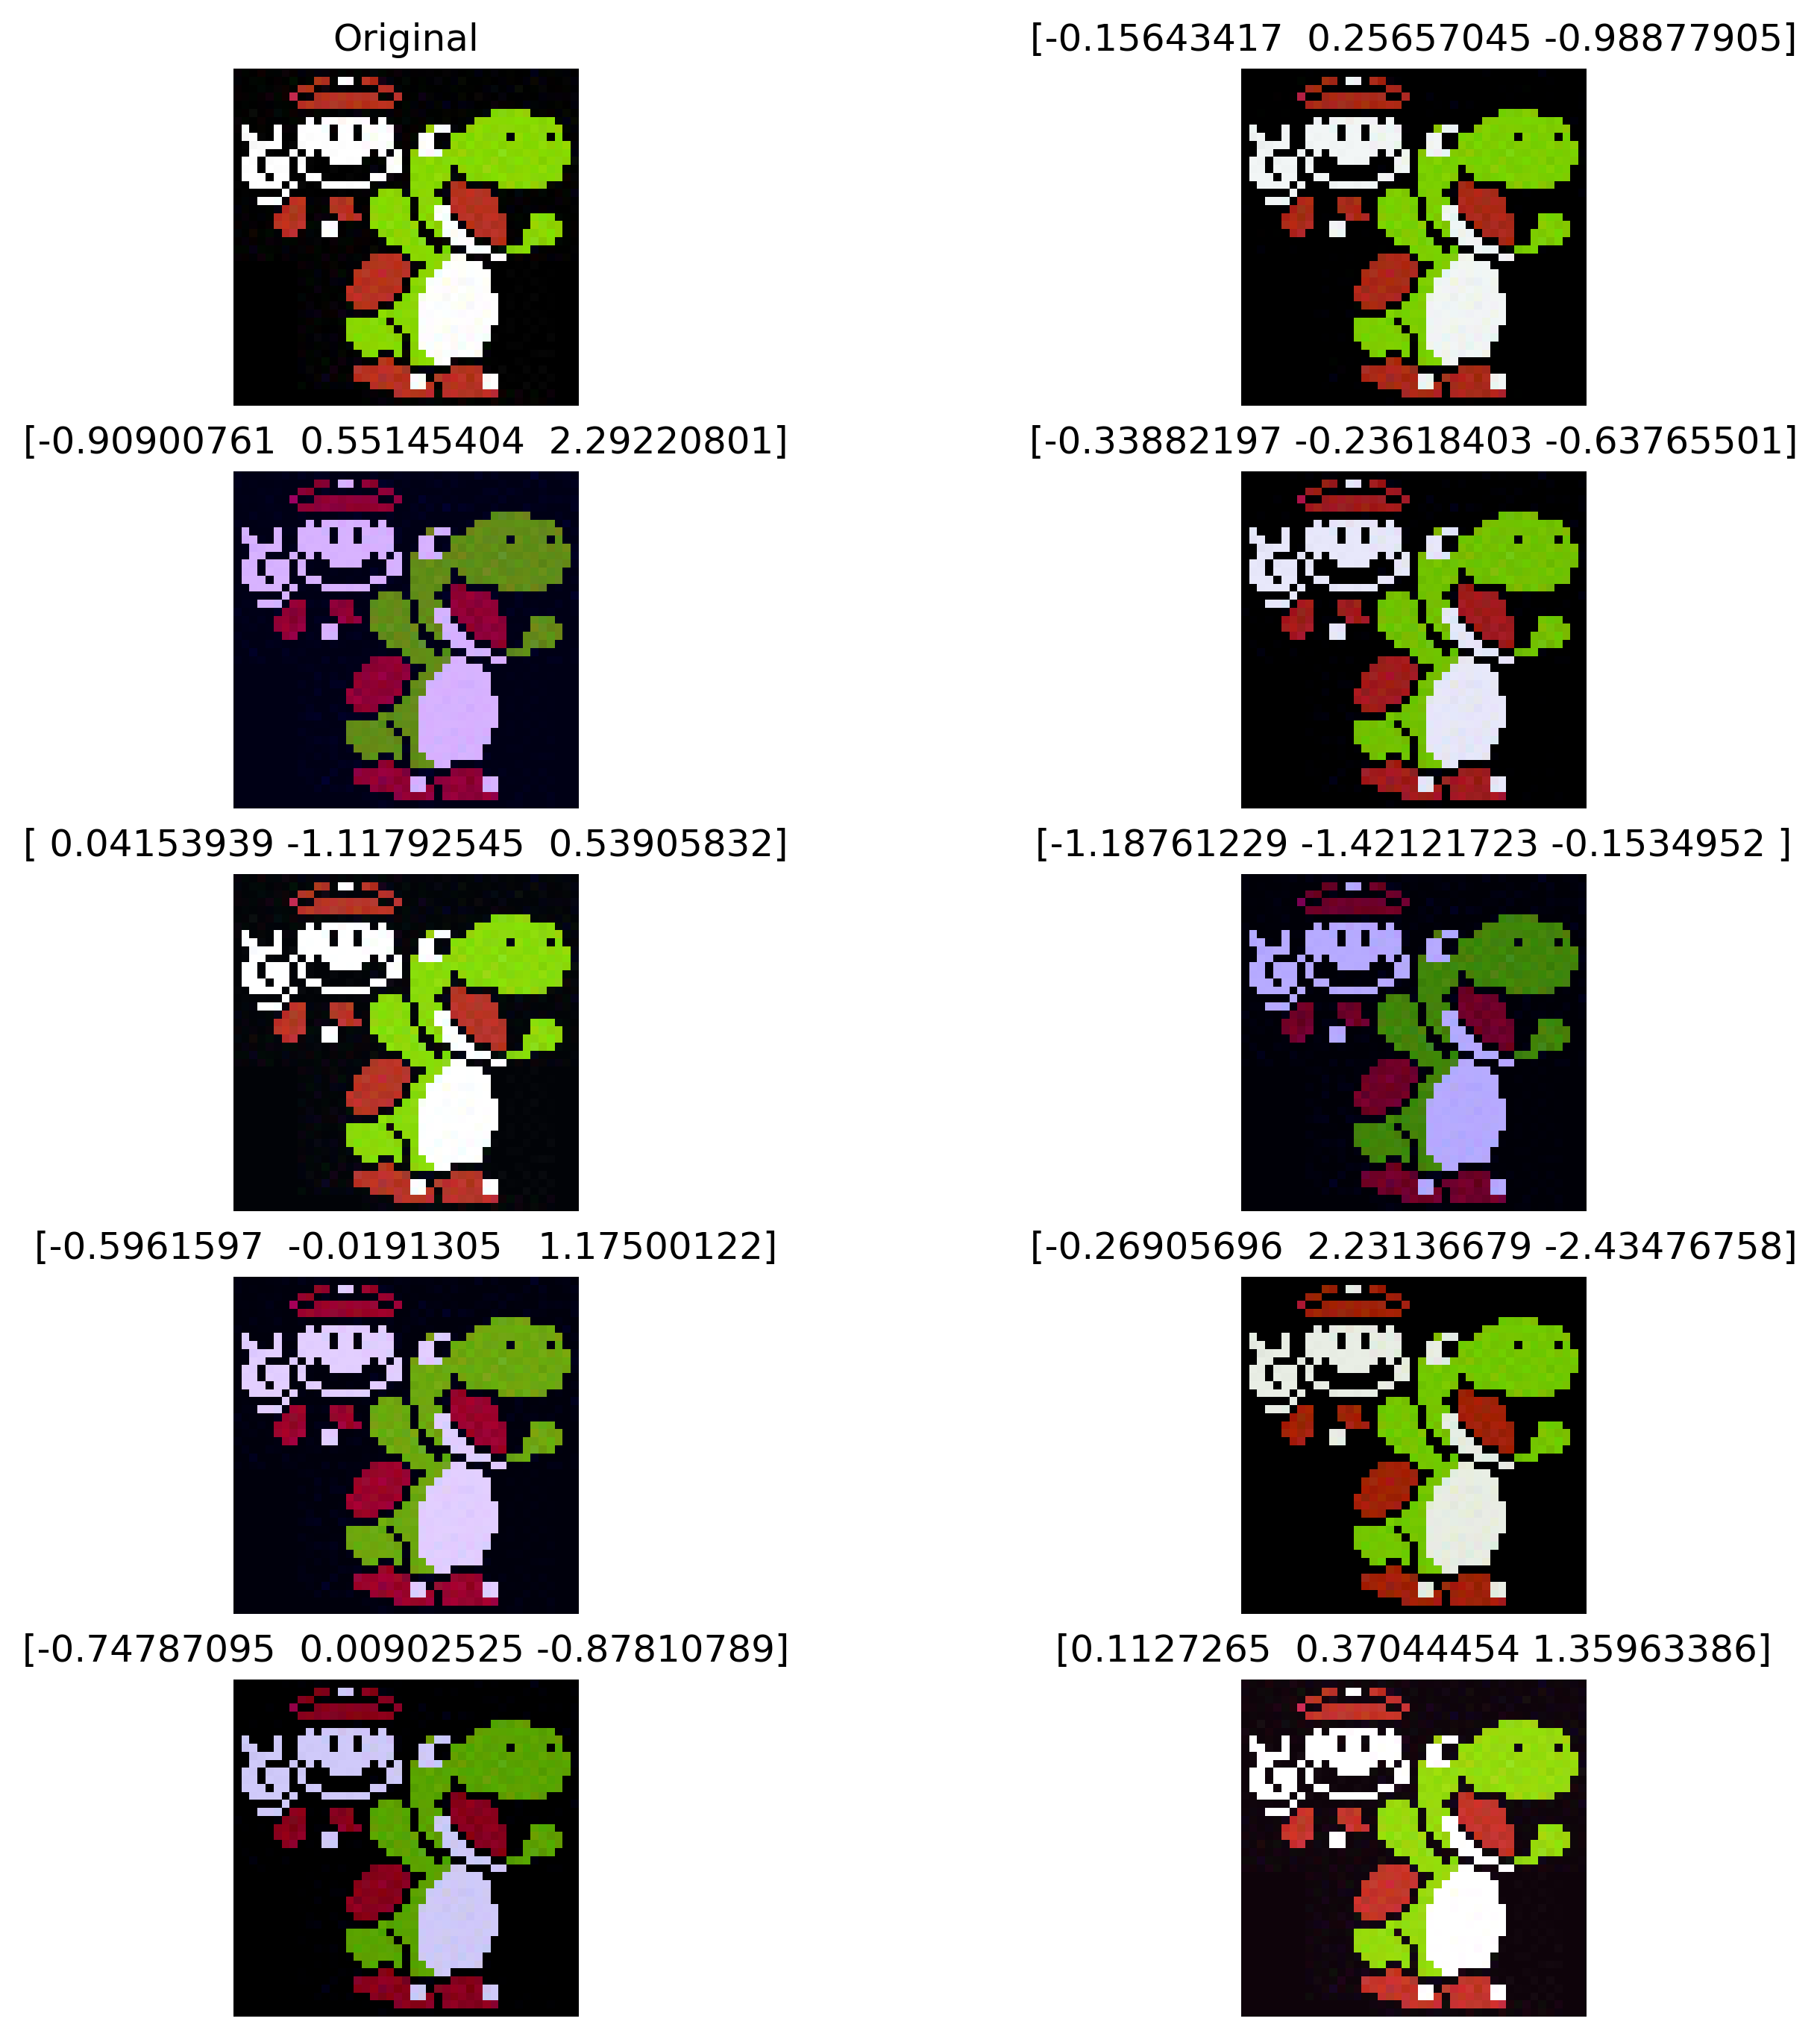

In [19]:
# Create our figure as a grid
ncols = 2
nrows = 5
fig1, f1_axes = plt.subplots(ncols=ncols, nrows=nrows, constrained_layout=True, figsize=(9,9), facecolor='white')
num_images = ncols*nrows

fig1.set_dpi(300.0)

# Plot our original image
#input_img = plt.imread("Images/Mario.png") # Already a float
input_img = to_float(plt.imread("Images/Yoshi.jpg"))
ax = f1_axes[0][0]
ax.set_axis_off()
ax.set_title("Original")
ax.imshow(input_img)

# Plot the modified images
for c in range(ncols):
    for r in range(nrows):
        if c == 0 and r == 0:
            continue
        # Modified image
        alphas = np.random.normal(0, 1, 3)
        output_img = augment(input_img, alphas)
        ax = f1_axes[r][c]
        ax.set_axis_off()
        ax.set_title(str(alphas))
        ax.imshow(np.asarray(output_img))

plt.show()

It works! I emailed Dr. Raissi to verify this as well. We can see that some images are brighter and others are darker. We can now use this for data augmentation when training image classifiers, though I don't do that in this report.

## 3: Transfer Learning

I now want to do transfer learning! I'll be using the [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats) dataset I found on Kaggle, and transferring the ResNet50 model to classifying dogs and cats. The goal is to use the final average pooling layer as input to a custom fully connected layer which I re-train. I chose this dataset because it's small and easy to test with, allowing me to learn how transfer learning is implemented without wrestling with data size limits. I had to create my own training and validation splits because the dataset doesn't come with any of its own. I followed [this tutorial](https://towardsdatascience.com/recognizing-cats-and-dogs-with-tensorflow-105eb56da35f) to load the images from Kaggle (since it's easier to work with than Tensorflow's datasets). I also had to swap out the tutorial's `ImageDataGenerator` with [`image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) because the latter is deprecated.

In [20]:
import os
import shutil
import random

# My directories for where I downloaded kaggle data to where I want the output to be
input_dir = '/tf/Datasets/kaggle/cats_vs_dogs'
output_dir = '/tf/Datasets/kaggle/cats_vs_dogs_parsed'

# Function to create a new folder with the generated splits
def distribute_train_validation_split(validation_size=0.2):
    # Get an array of all of the names of the images from Kaggle
    all_images = os.listdir(input_dir + '/train')
    
    # Shuffle the names of the images
    random.shuffle(all_images)

    # Get a list of the files whose name contain 'dog' and 'cat'
    all_dogs = list(filter(lambda image: 'dog' in image, all_images))
    all_cats = list(filter(lambda image: 'cat' in image, all_images))

    # Split the dogs and cats files based on validation size
    # This value is the closest integer to the number of files to have for validation
    index_to_split = int(len(all_dogs) * validation_size)
    
    training_dogs = all_dogs[index_to_split:]
    validation_dogs = all_dogs[:index_to_split]
    training_cats = all_cats[index_to_split:]
    validation_cats = all_cats[:index_to_split]

    # Remove all files in output before writing
    shutil.rmtree(output_dir)
    
    # Create output directories
    os.makedirs(output_dir + '/train/dogs/', exist_ok=True)
    os.makedirs(output_dir + '/train/cats/', exist_ok=True)
    os.makedirs(output_dir + '/validation/dogs/', exist_ok=True)
    os.makedirs(output_dir + '/validation/cats/', exist_ok=True)

    # Custom function to copy input file names to output directory
    copy_images_to_dir(training_dogs, output_dir + '/train/dogs')
    copy_images_to_dir(validation_dogs, output_dir + '/validation/dogs')
    copy_images_to_dir(training_cats, output_dir + '/train/cats')
    copy_images_to_dir(validation_cats, output_dir + '/validation/cats')

# Helper function to copy input file names to output directory
def copy_images_to_dir(images_to_copy, destination):
    for image in images_to_copy:
        shutil.copyfile(f'{input_dir}/train/{image}', f'{destination}/{image}')

# Create our output based on percentage for validation and training
distribute_train_validation_split(0.25)

In [21]:
# Note: the default batch size is 32

# Load the generated splits from the previous code block into a training and validation dataset

batch_sz = 32

custom_train = tf.keras.utils.image_dataset_from_directory(
    output_dir + '/train',
    labels='inferred', # Labels from directory structure
    image_size=(224, 224), # Resnet50 expected input
    label_mode = 'binary', # 2 classes
    batch_size = batch_sz
)

custom_val = tf.keras.utils.image_dataset_from_directory(
    output_dir + '/validation',
    labels='inferred', # Labels from directory structure
    image_size=(224, 224), # Resnet50 expected input
    label_mode = 'binary', # 2 classes
    batch_size = batch_sz
)

# Variables used later, based on the output of this code block
epochs = 3
train_ims = 7102
val_ims = 2420

custom_train = custom_train.repeat(epochs)
custom_val = custom_val.repeat(epochs)

Found 7102 files belonging to 2 classes.
Found 2420 files belonging to 2 classes.


Let's print some examples to see what kind of data we're dealing with (not because I want to look at pictures of animals... even though they're very cute... and now I want to go visit my parents cat lol).

Training data sample:


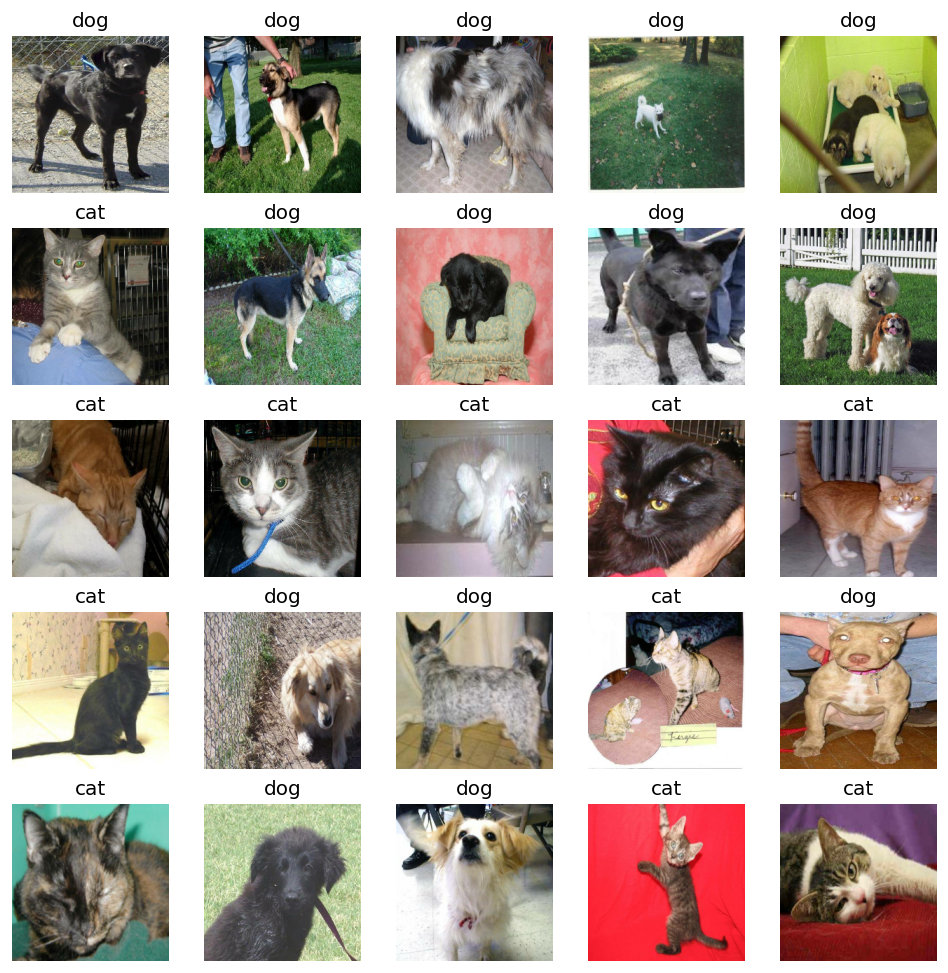

In [22]:
print("Training data sample:")

iterator = iter(custom_train)
batch = iterator.get_next()

# Create our figure as a grid
ncols = 5
nrows = 5
fig1, f1_axes = plt.subplots(ncols=ncols, nrows=nrows, constrained_layout=True, figsize=(8,8), facecolor='white')
num_images = ncols*nrows

fig1.set_dpi(120.0)

# Plot the modified images
for c in range(ncols):
    for r in range(nrows):
        image = batch[0][nrows*r+c]
        label = "dog" if int(batch[1][nrows*r+c].numpy()[0]) else "cat"
        
        ax = f1_axes[r][c]
        ax.set_axis_off()
        ax.set_title(label)
        ax.imshow(np.asarray(image).astype(float)/255)

plt.show()

Validation data sample:


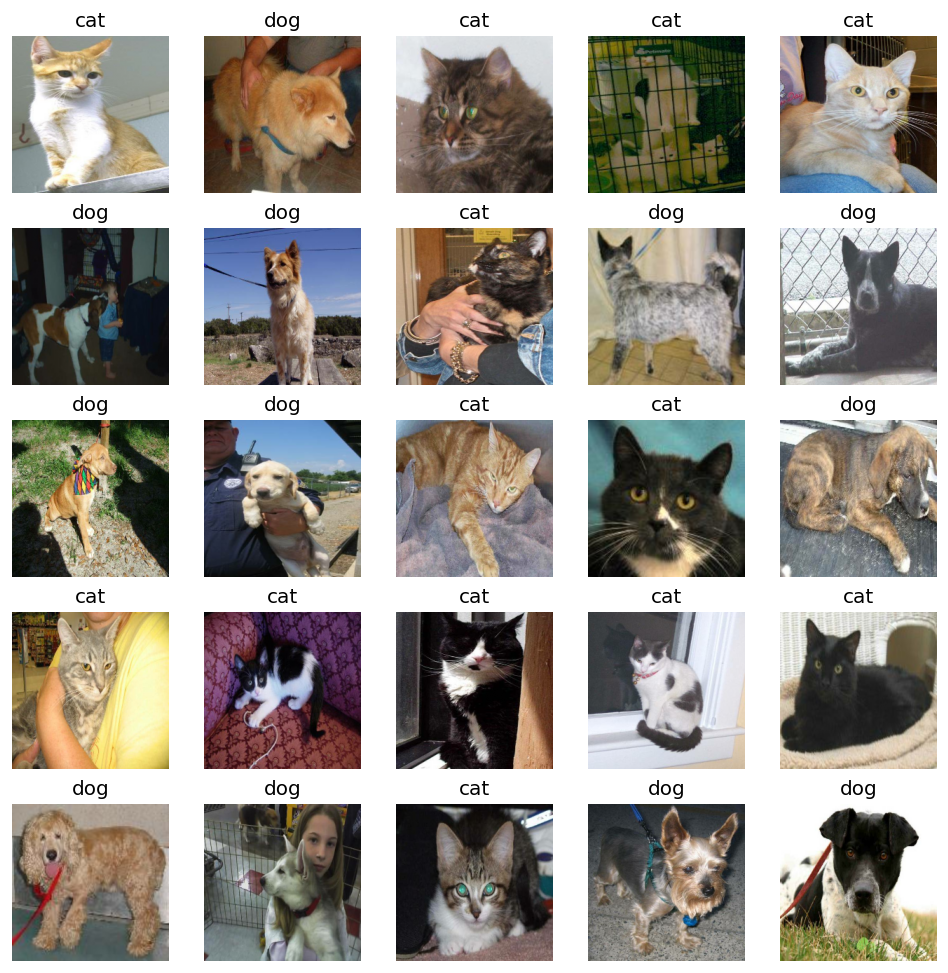

In [23]:
print("Validation data sample:")

iterator = iter(custom_train)
batch = iterator.get_next()

# Create our figure as a grid
ncols = 5
nrows = 5
fig1, f1_axes = plt.subplots(ncols=ncols, nrows=nrows, constrained_layout=True, figsize=(8,8), facecolor='white')
num_images = ncols*nrows

fig1.set_dpi(120.0)

# Plot the modified images
for c in range(ncols):
    for r in range(nrows):
        image = batch[0][nrows*r+c]
        label = "dog" if int(batch[1][nrows*r+c].numpy()[0]) else "cat"
        
        ax = f1_axes[r][c]
        ax.set_axis_off()
        ax.set_title(label)
        ax.imshow(np.asarray(image).astype(float)/255)

plt.show()

Next, I skimmed [this tutorial](https://keras.io/guides/transfer_learning/) to get ResNet50 loaded.

In [24]:
# Load ResNet 50
rn50 = tf.keras.applications.resnet50.ResNet50(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000
)

# Print helpful information
layer_num = len(rn50.layers)
print("Number of layers:", layer_num)
print()

j = 3

# Print last j layers (with their configs) in order:
for i in range(j):
    print(rn50.get_layer(index = layer_num - j + i).get_config())
    print()

Number of layers: 177

{'name': 'conv5_block3_out', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}

{'name': 'avg_pool', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}

{'name': 'predictions', 'trainable': True, 'dtype': 'float32', 'units': 1000, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}



Now that I have ResNet50 loaded, I can modify it to the dog/cat classification task. I will be using the average pooling layer, which can be though of as the "feature" layer, and append some densely connected layer which I can train to classify cats and dogs. First, however, I need to make sure that I loaded ResNet50 properly, so I try classifying one of the images. I found out that I had to scale the input image to size (224,224,3) to get this to work. Luckily, [`image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) does this automatically so my `custom_train` and `custom_val` datasets have the properly scaled images. Note that I had to pass my image through [`tf.keras.applications.resnet50.preprocess_input`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input) first, according to the  [TensorFlow ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50) page.

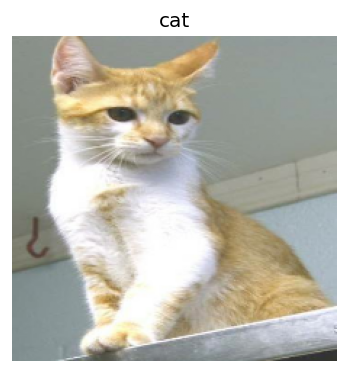

In [25]:
# Plot one image from the cats vs dogs dataset with the true label

# Take the first image of the cats vs dogs dataset

image = batch[0][0]
label = "dog" if int(batch[1][0].numpy()[0]) else "cat"

fig1, f1_axes = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(3,3), facecolor='white')

fig1.set_dpi(120.0)
ax = f1_axes
ax.set_axis_off()
ax.set_title(label)
ax.imshow(np.asarray(image).astype(float)/255)
print()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ImageNet label is: 285 Egyptian cat




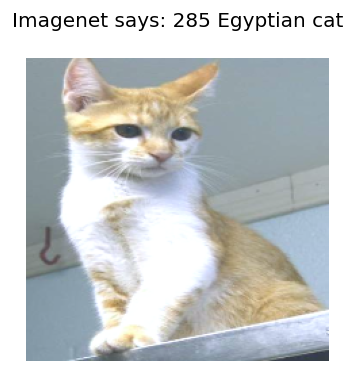

In [26]:
# Plot one image from the cats vs dogs dataset with the imagenet label

# Convert to numpy array, had to copy here because otherwise it wasn't writable
np_image = np.copy(np.asarray(image))
np_image = np_image

im = tf.keras.utils.img_to_array(np_image)

# Add a fourth dimension, effectively making a "batch" of size 1 image
im = np.expand_dims(im, axis=0)

# Get label of our image, need to preprocess it according to Tensorflow page on ResNet 50
tf.keras.applications.resnet50.preprocess_input(im)
result = rn50(im)
result_max = tf.math.reduce_max(result)
cond = tf.equal(result, result_max)
idx = tf.where(cond)

# Get labels as strings
labels = open("/tf/Datasets/labels.txt", "r")
labels.seek(0)
labels_list = labels.readlines()
labels.close()

label = labels_list[idx[0][-1]]

# Print label
print("ImageNet label is:", label)

# Print image
fig1, f1_axes = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(3,3), facecolor='white')

fig1.set_dpi(120.0)
ax = f1_axes
ax.set_axis_off()
ax.set_title("Imagenet says: " + label)

# The preprocess_input function subtracts 127.5 from our image, so I add it then divide by 255 for [0., 1.] images
ax.imshow(np.asarray(im[0]+127.5)/255)
print()

Great! Luckily for us, Imagenet already has cat and dog related labels, and so when we loaded the weights for ImageNet for the ResNet50 model, we are easily able to classify the above image. Lets now Frankenstein this model by replacing the last densely connected layer of 1,000 nodes with a densely connected layer of 1 node to make a binary classifier. We need to re-load the model with the `include_top` variable as `False` and `pooling` as `avg` to remove the dense layer at the end and keep the average pooling layer.

In [27]:
# Load ResNet 50 Frankenstein
rn50 = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling='avg'
)

We should then have the output as the average pooling layer.

In [28]:
# Set rn50 weights to non-trainable
rn50.trainable = False

# Print helpful information
layer_num = len(rn50.layers)
print("Number of layers:", layer_num)
print()

j = 3

# Print last j layers in order:
for i in range(j):
    print(rn50.get_layer(index = layer_num - j + i).get_config())
    print()

Number of layers: 176

{'name': 'conv5_block3_add', 'trainable': False, 'dtype': 'float32'}

{'name': 'conv5_block3_out', 'trainable': False, 'dtype': 'float32', 'activation': 'relu'}

{'name': 'avg_pool', 'trainable': False, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}



Looks like the average pooling layer is there, so we'll be adding one more layer to this version of ResNet50:

- 1 Neuron Dense Layer (Binary classification)

I used some code from [here](https://keras.io/guides/transfer_learning/#the-typical-transferlearning-workflow) to get this next bit to work.

In [29]:
# Create our frankenstein model with same input size
franken = keras.Sequential(
    [keras.Input(shape=(None,None,3), name="input"), 
     rn50,
     keras.layers.Dense(1, activation='relu', name='output',
                        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=14),
                        trainable=True)]
)

Let's pass in a few of the initial images of the cats vs dogs dataset and see what we get:

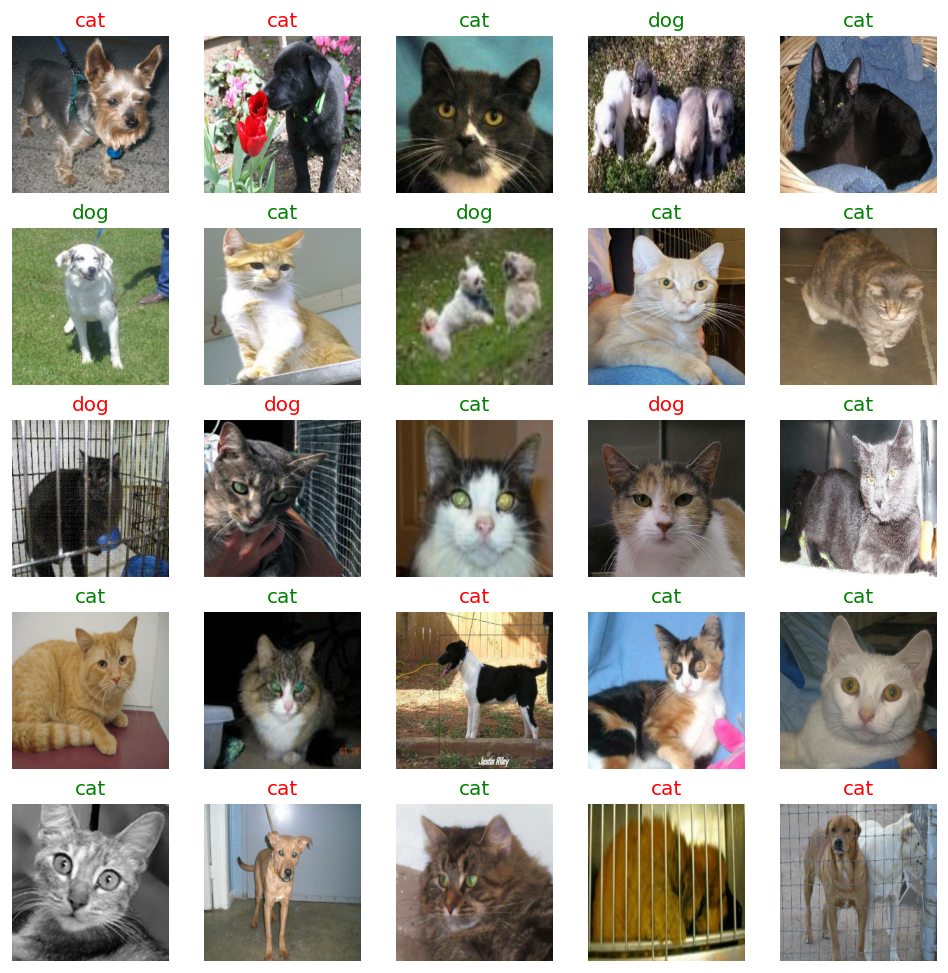

In [30]:
iterator = iter(custom_train)
batch = iterator.get_next()

# Create our figure as a grid
ncols = 5
nrows = 5
fig1, f1_axes = plt.subplots(ncols=ncols, nrows=nrows, constrained_layout=True, figsize=(8,8), facecolor='white')
num_images = ncols*nrows

fig1.set_dpi(120.0)

# Plot the modified images
for c in range(ncols):
    for r in range(nrows):
        # Get image and label from dataset
        image = batch[0][nrows*r+c]
        label = "dog" if int(batch[1][nrows*r+c].numpy()[0]) else "cat"
        
        image_extra = np.expand_dims(np.copy(image), axis=0)
        
        # Then, pass it through the provided preprocessing funciton (not sure if this is needed)
        tf.keras.applications.resnet50.preprocess_input(image_extra)
        
        ax = f1_axes[r][c]
        ax.set_axis_off()
        guess = "dog" if franken(image_extra).numpy()[0][0] > 0 else "cat"
        ax.set_title(guess,
                    fontdict = {'color': "green" if label == guess else "red"})
        ax.imshow(np.asarray(image).astype(float)/255)

plt.show()

Not very good! But we can take this as a challenge since we haven't even trained the model yet. Let's do that.

In [36]:
# Train the model

# Set resnet50 weights as static
rn50.trainable = False

# Make sure the images we're training over are pre-processed to fit resnet50's expected input
def pre_image(input_im):
    return tf.keras.applications.resnet50.preprocess_input(input_im)
custom_train_2 = custom_train.map(lambda x, y: (pre_image(x), y))

# Our model
franken = keras.Sequential(
    [keras.Input(shape=(None,None,3), name="input"), 
     rn50,
     keras.layers.Dense(1, activation='relu', name='output',
                        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=14),
                        trainable=True)],
    name = "franken"
)

# Our optimizer (I did this to increase the learning rate)
nadam = tf.keras.optimizers.Nadam(
    learning_rate=0.01,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    name='Nadam'
)

franken.compile(optimizer=nadam,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

print("Summary of our franken model:")
franken.summary()

print()

print("Weights of the last layer:")
print(np.hstack(franken.get_layer("output").get_weights()[0]))

Summary of our franken model:
Model: "franken"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 output (Dense)              (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________

Weights of the last layer:
[ 0.00948041 -0.04314274 -0.04702336 ...  0.02634949 -0.04982909
 -0.04293229]


In [37]:
# This is from an error I was getting with the input data not being large enough:
# https://stackoverflow.com/questions/60509425/how-to-use-repeat-function-when-building-data-in-keras
steps_per_epoch = train_ims // batch_sz
validation_steps = val_ims // batch_sz

# Run our fitting routine
history = franken.fit(custom_train_2,
                    validation_data=custom_val,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_steps=validation_steps)

print()
print("Weights of the last layer:")
print(np.hstack(franken.get_layer("output").get_weights()[0]))

Epoch 1/3
221/221 [==============================] - 30s 126ms/step - loss: 0.3913 - accuracy: 0.9648 - val_loss: 0.3869 - val_accuracy: 0.9467
Epoch 2/3
221/221 [==============================] - 27s 123ms/step - loss: 0.3621 - accuracy: 0.9774 - val_loss: 0.3799 - val_accuracy: 0.9567
Epoch 3/3
221/221 [==============================] - 27s 124ms/step - loss: 0.3572 - accuracy: 0.9827 - val_loss: 0.3831 - val_accuracy: 0.9558

Weights of the last layer:
[ 0.0315255  -0.06299642 -0.11062516 ...  0.026603   -0.15335274
  0.25665882]


The accuracy values above look promising! Note that this method converges or diverges depending on the initial random values of the weights. I was unsuccessful in figuring out how to make the initial weights the same across runs, so if anyone has any advice I'm all ears!

Lets re-classify with our updated model!

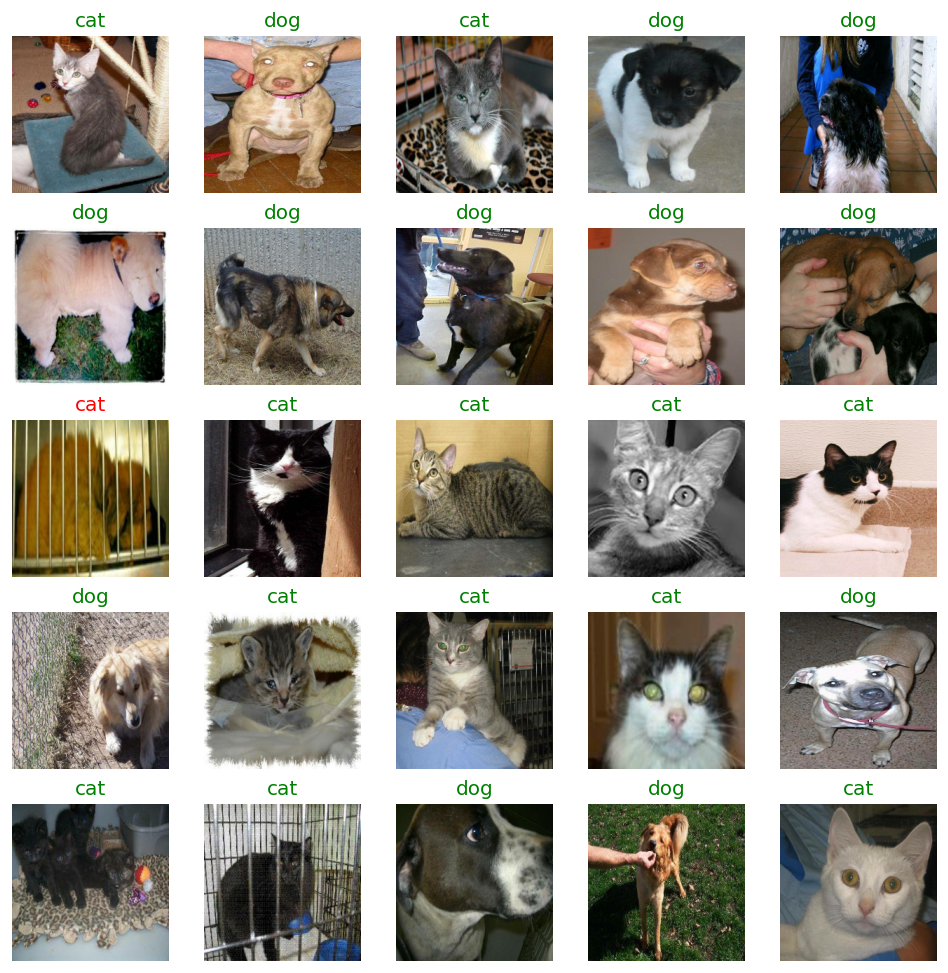

In [38]:
iterator = iter(custom_train)
batch = iterator.get_next()

# Create our figure as a grid
ncols = 5
nrows = 5
fig1, f1_axes = plt.subplots(ncols=ncols, nrows=nrows, constrained_layout=True, figsize=(8,8), facecolor='white')
num_images = ncols*nrows

fig1.set_dpi(120.0)

# Plot the modified images
for c in range(ncols):
    for r in range(nrows):
        # Get image and label from dataset
        image = batch[0][nrows*r+c]
        label = "dog" if int(batch[1][nrows*r+c].numpy()[0]) else "cat"
        
        image_extra = np.expand_dims(np.copy(image), axis=0)
        
        # Then, pass it through the provided preprocessing funciton (not sure if this is needed)
        tf.keras.applications.resnet50.preprocess_input(image_extra)
        
        ax = f1_axes[r][c]
        ax.set_axis_off()
        guess = "dog" if franken(image_extra).numpy()[0][0] > 0 else "cat"
        ax.set_title(guess,
                    fontdict = {'color': "green" if label == guess else "red"})
        ax.imshow(np.asarray(image).astype(float)/255)

plt.show()

Much better! Of course, we don't have 100% accuracy, but an accuracy of over 95% is very good!

# Conclusions and future work


I am happy that all of the sections in my report were successful. Each of these sections touches upon something that we talked about in leacture and gives me code I can use moving forward. My goal for the next report is to use transfer learning in conjunction with data augmentation to see if I can further improve the accuracy of my model.